In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


## Load data

In [2]:
# load data and convert timestamp to pandas date time fomat

def load_data(df_name):
    df = pd.read_csv(df_name + ".csv", sep= '\t')
    
    df[df_name.split('_')[0] + '_date'] = pd.to_datetime(df[df_name.split('_')[0]+'_ts'] , unit = 'ms')
    
    return df

# Load call data
call_df = load_data('call_data')

# Load message data
message_df = load_data('message_data')

# Load search data
search_df = load_data('search_data')

# Load signup data
signup_df = load_data('signup_data')


In [3]:
print("Call dataframe\n")
print(call_df.head())

print("\nMessage dataframe\n")
print(message_df.head())

print("\nSearch dataframe\n")
print(search_df.head())

print("\nSignup dataframe\n")
print(signup_df.head())

Call dataframe

    user_id        call_ts               call_date
0  10016547  1554294993128 2019-04-03 12:36:33.128
1  10022130  1553790875089 2019-03-28 16:34:35.089
2  10020436  1553083077679 2019-03-20 11:57:57.679
3  10004031  1553984897628 2019-03-30 22:28:17.628
4  10001845  1553445030753 2019-03-24 16:30:30.753

Message dataframe

    user_id     message_ts            message_date
0  10024239  1553986083696 2019-03-30 22:48:03.696
1  10021388  1553197787973 2019-03-21 19:49:47.973
2  10022286  1552931128388 2019-03-18 17:45:28.388
3  10023459  1553519190682 2019-03-25 13:06:30.682
4  10023112  1553967251566 2019-03-30 17:34:11.566

Search dataframe

    user_id      search_ts             search_date
0  10001110  1554188089059 2019-04-02 06:54:49.059
1  10001010  1553159392120 2019-03-21 09:09:52.120
2  10018492  1554296508598 2019-04-03 13:01:48.598
3  10008817  1553186210012 2019-03-21 16:36:50.012
4  10015005  1554189287541 2019-04-02 07:14:47.541

Signup dataframe

    user

In [4]:
print("Shape of call df: {}".format(call_df.shape))
print("Shape of message df: {}".format(message_df.shape))
print("Shape of search df: {}".format(search_df.shape))
print("Shape of signup df: {}".format(signup_df.shape))

Shape of call df: (1223795, 3)
Shape of message df: (105785, 3)
Shape of search df: (867131, 3)
Shape of signup df: (26000, 4)


In [5]:
call_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223795 entries, 0 to 1223794
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   user_id    1223795 non-null  int64         
 1   call_ts    1223795 non-null  int64         
 2   call_date  1223795 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 28.0 MB


# Exploratory Data Analysis 

The aim of this notebook is to analyse and interpret all four datasets and generate insights. Which could essentially help us to indentify and make conclusion about potential fraudulent activities. 

# User behavior/ activity

### Analyse signup data

The idea is to figure out on average how many users signup per day or per hour. It's also interesting to know for which country code most signup takes place.

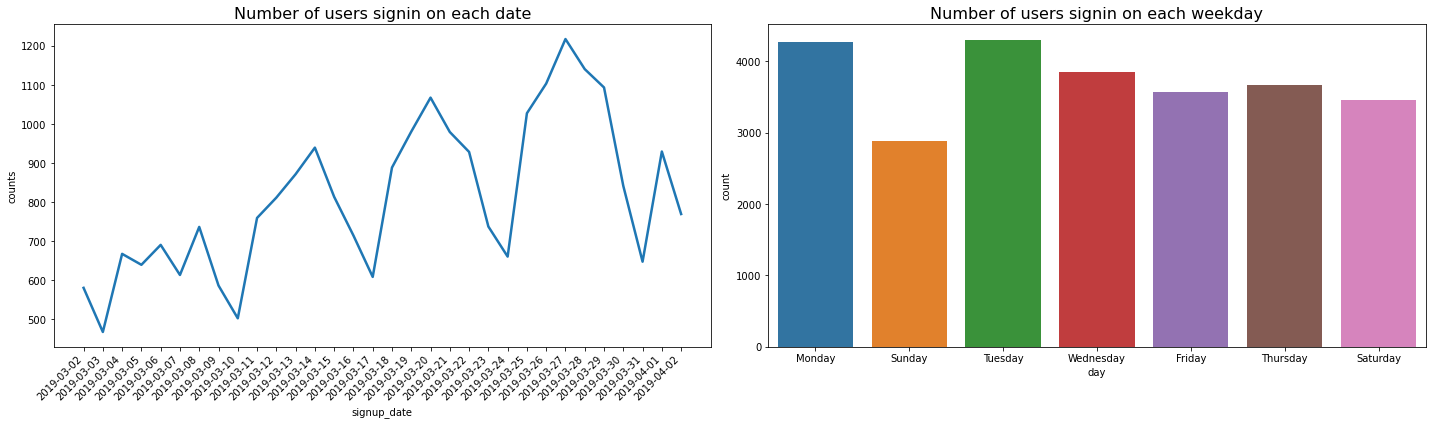

In [6]:
# 1. Visualize number of users on each day 

signup_day = signup_df.groupby(signup_df['signup_date'].dt.strftime('%Y-%m-%d'))['user_id'].count().reset_index(name= 'counts')
x_dates = signup_df['signup_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20,6))

sns.lineplot(x= 'signup_date', y= 'counts', data = signup_day, linewidth = 2.5, ax= ax[0])
ax[0].set_xticklabels( labels=x_dates, rotation=45, ha='right') 
ax[0].set_title('Number of users signin on each date', fontsize = 16)

# 2. Visualize number of users on each weekday
# Get the weekday name using dt.day_name()

signup_df['day'] = signup_df['signup_date'].dt.day_name()

sns.countplot(x = 'day', data = signup_df, ax= ax[1])
ax[1].set_title('Number of users signin on each weekday', fontsize=16)

plt.tight_layout()
plt.show()

The line plot suggests that there is a increasing signup trend by users over time. It is also obvious that there exit peaks followed by drops  on the line for certain days, which suggests existing of seasonality on this time series data.

The bar plot on right reveals, Monday and Tuesday are the days when users sigup most compare to other weekdays.

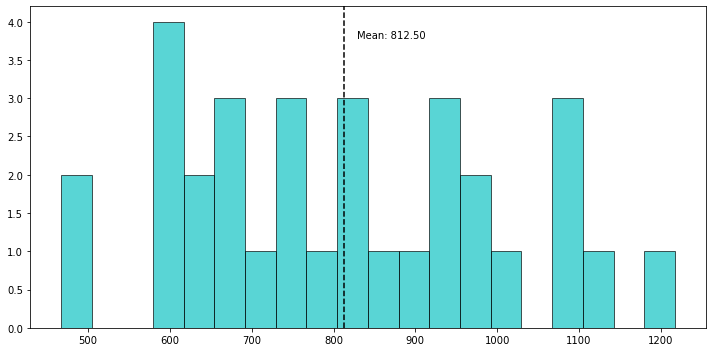

In [862]:
# Visualize the distribution of signup numbers

signup_day = signup_df.groupby(pd.Grouper(key= 'signup_date', freq= 'D'))['user_id'].count().reset_index(name= 'count')

plt.figure(figsize=(10,5))

plt.hist(signup_day['count'], bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(signup_day['count'].mean(), color='k', linestyle='dashed', linewidth=1.5)

min_ylim, max_ylim = plt.ylim()
plt.text(signup_day['count'].mean()*1.02, max_ylim*0.9, 'Mean: {:.2f}'.format(signup_day['count'].mean()))

plt.tight_layout()
plt.show()

By looking at the distribution of the number of signup on each date, it reveals that about on average 813 signup achieve per day from users.

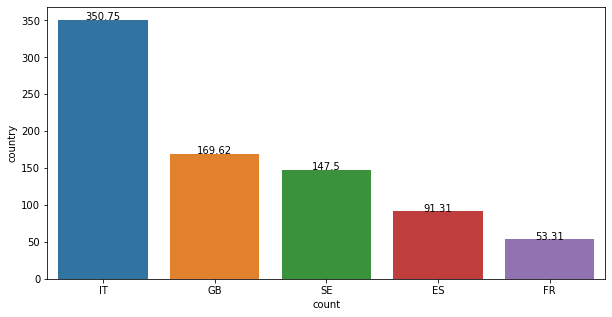

In [799]:
# Visualize the distribution of signup by country code

plt.figure(figsize=(10,5))
country_df = signup_df.groupby(['country_code', pd.Grouper(key= 'signup_date', freq= 'D')])['user_id'].count().reset_index(name= 'counts') 

groupedvalues= country_df.groupby('country_code')['counts'].mean().reset_index(name = 'avg_count')
groupedvalues = groupedvalues.sort_values(by= 'avg_count', ascending=False).reset_index()
g=sns.barplot(x='country_code',y='avg_count',data=groupedvalues)

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.avg_count, round(row.avg_count,2), color='black', ha="center")
    
plt.xlabel('count')
plt.ylabel('country')

plt.show()

The above distribution suggests, on an average for each day, the highest signup received from country code "IT" compare to other countries.

### Analyse call data

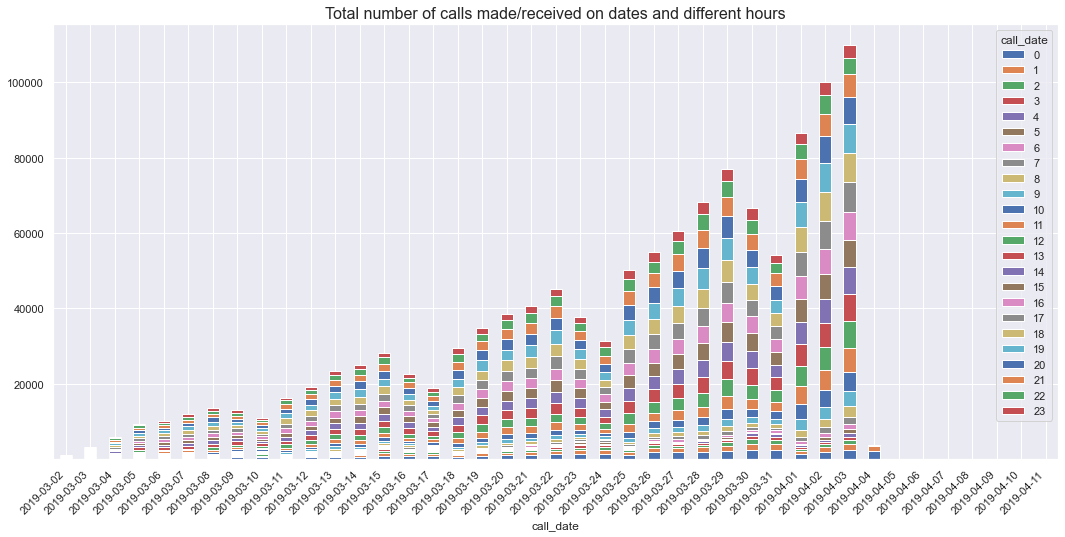

In [64]:
# 1. Visualize count of users on each date 
# Stacked bar char using pandast plot()

x_dates = call_df['call_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

sns.set()

fig, ax = plt.subplots(figsize=(18,8))

call_df.groupby([call_df['call_date'].dt.strftime('%Y-%m-%d'), call_df['call_date'].dt.hour ]).size()\
                    .unstack() \
                    .plot(kind='bar',stacked=True,  ax= ax) 

ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Total number of calls made/received on dates and on different hours', fontsize = 16)

plt.show()

The increasing trend visible on the plot above. It also shows that more calls were made/received during day time between 11 to 20 o'clock.

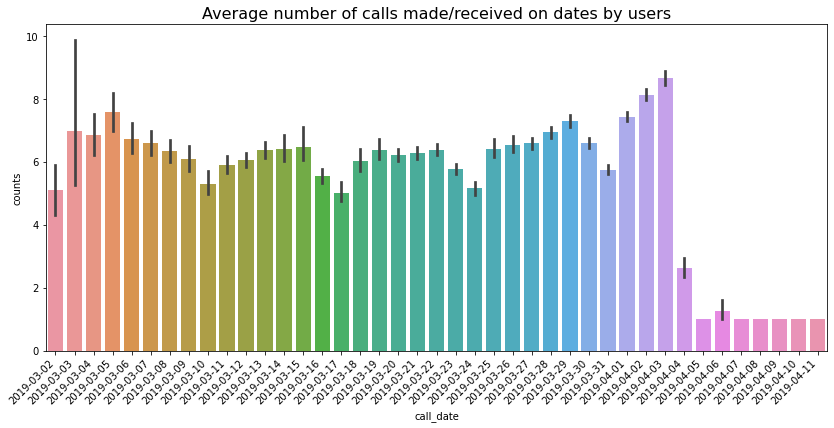

In [113]:
# 1. Visualize count of users on each date 

user_date_df = call_df.groupby(['user_id', pd.Grouper(key= 'call_date', freq='D')])['call_date'].count().reset_index(name = 'counts')
x_dates = call_df['call_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x = 'call_date', y= 'counts',  data = user_date_df)
ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Average number of calls made/received on dates by users', fontsize = 16)

plt.show()

### Let's check for outliers in data

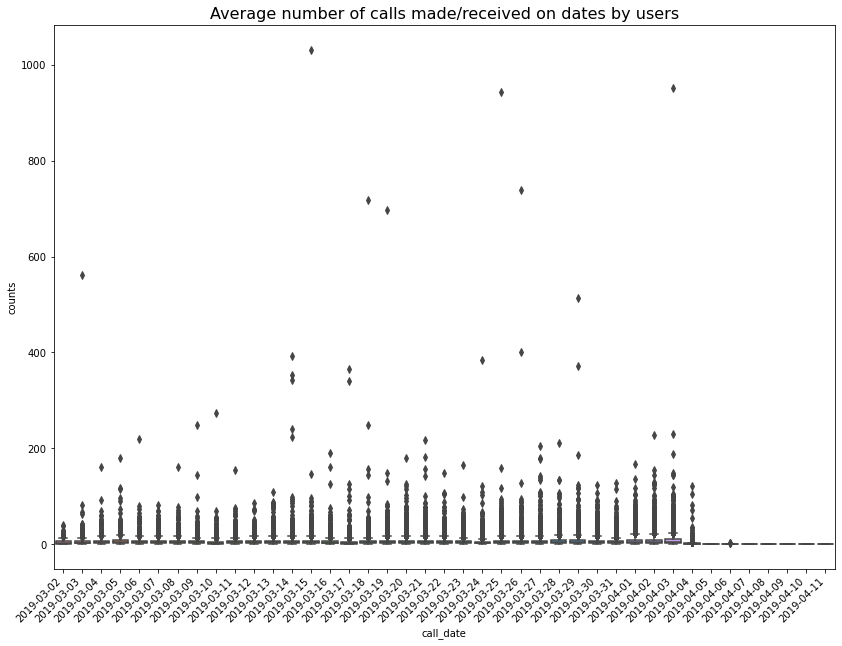

In [114]:
# Box plot to see the distribution on each day and find anomaly.
fig, ax = plt.subplots(figsize=(14,10))

sns.boxplot(x = 'call_date', y= 'counts',  data = user_date_df)
ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Average number of calls made/received on dates by users', fontsize = 16)

plt.show()

The bar plot shows the mean values and provides some indication of the uncertainty around that estimate using error bars. The graph shows that threre were more calls made/received on 2nd and 3rd april in 2019. On those days users made/received about 9 calls on an average.

In addition, from the boxplot next, suggests that we have a very spread distribution for this call data on each day. The points outside the box are particularly outliers as there are not included in the box of other observation. This include that, there exist high anomaly values which need to take care.

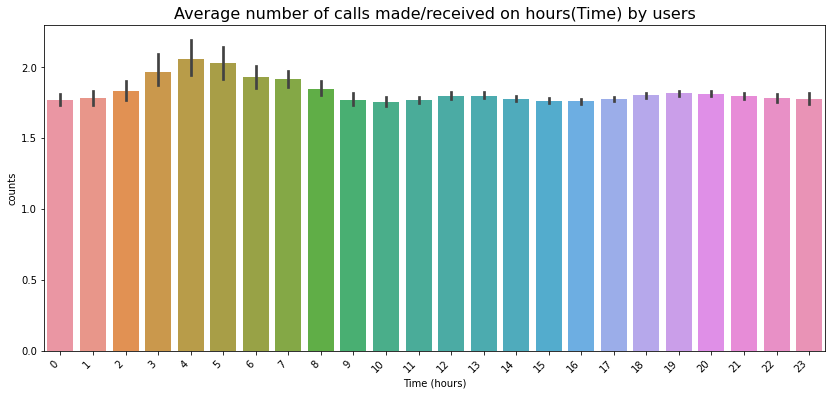

In [115]:
# 1. Visualize count of users on each hour 

user_hour_df = call_df.groupby([ 'user_id', pd.Grouper(key= 'call_date', freq='H')])['call_date'].count().reset_index(name = 'counts')
x_hours = call_df['call_date'].dt.hour.sort_values().unique()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x = user_hour_df['call_date'].dt.hour, y= 'counts',  data = user_hour_df)
ax.set_xticklabels(labels= x_hours, rotation=45, ha='right') 
ax.set_xlabel('Time (hours)')
ax.set_title('Average number of calls made/received on hours(Time) by users', fontsize = 16)

plt.show()


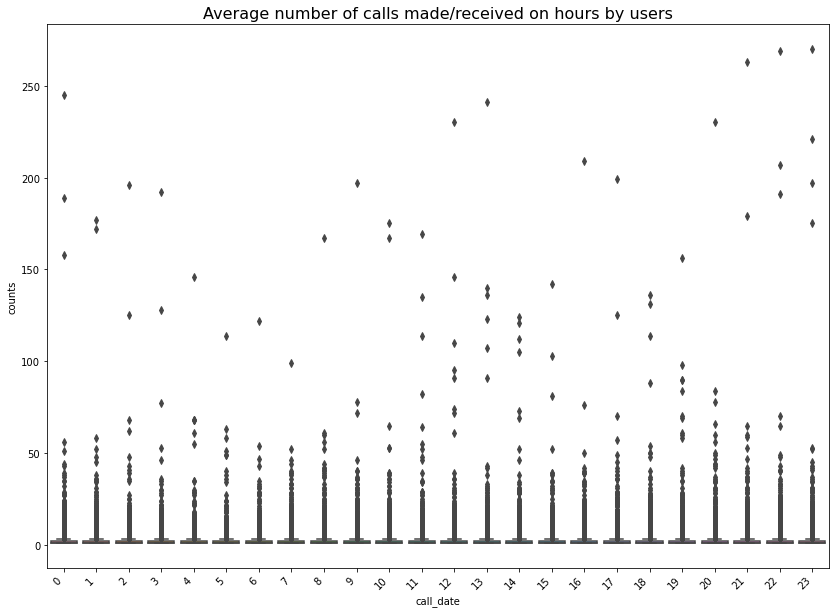

In [116]:
# Box plot to see the distribution on each day and find anomaly.
fig, ax = plt.subplots(figsize=(14,10))

sns.boxplot(x = call_hourly['call_date'].dt.hour, y= 'counts',  data = call_hourly)
ax.set_xticklabels(labels= x_hours, rotation=45, ha='right') 
ax.set_title('Average number of calls made/received on hours by users', fontsize = 16)

plt.show()

Threre were on average 2 calls made/received by users at time 4 o'clock. This means high call made/received on early in the morning otherwise the rest of the day hourly average call numbers are almost stable.

In addition, the distribution of hourly calls are also so spread using boxplot.

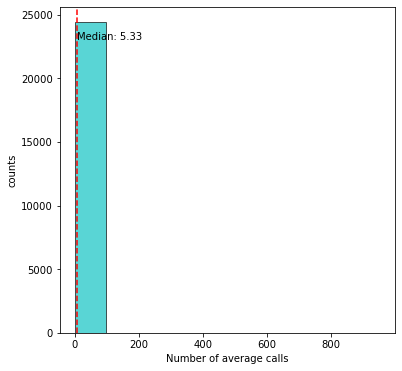

In [119]:
# Visualize the distribution of average users call made/received per day

user_date_df= call_df.groupby(['user_id', pd.Grouper(key= 'call_date', freq= 'D')])['user_id'].count().\
                reset_index(name= 'counts')
average = user_date_df.groupby('user_id')['counts'].mean().reset_index(name= 'average')

plt.figure(figsize=(6,6))
plt.hist(average['average'], bins=10, color='c', edgecolor='k', alpha=0.65)
plt.xlabel('Number of average calls')
plt.ylabel('counts')
plt.axvline(average['average'].median(), color='r', linestyle='dashed', linewidth=1.5)
min_ylim, max_ylim = plt.ylim()
# Plot the median value
plt.text(average['average'].median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(average['average'].median()))

plt.show()

On average the number of call made/received per day by each user is 6. Note that as the distribution is highly skewed, median is the most robast estimate for getting the central tendency of data instead of mean.

### Visualization of message dataframe

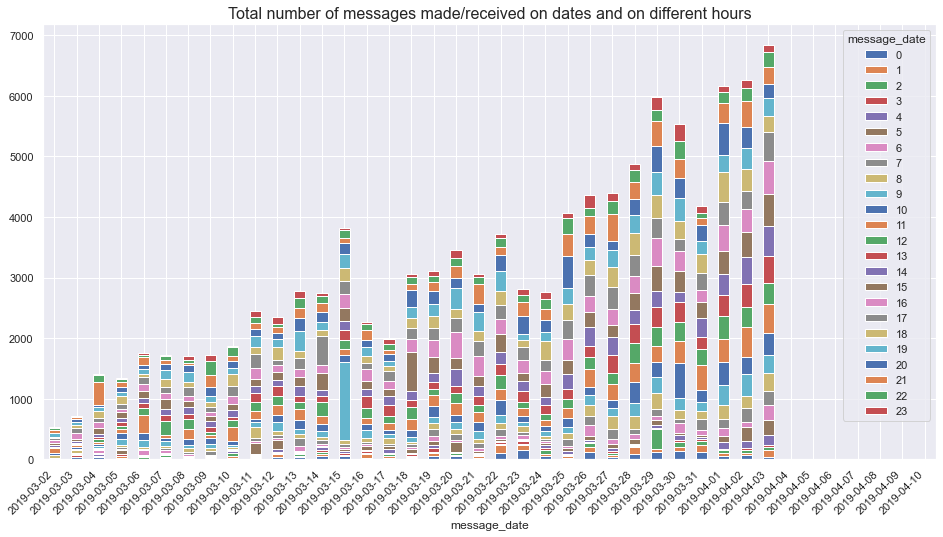

In [66]:
# 1. Visualize count of users on each date 
# Stacked bar char using pandast plot()

x_dates = message_df['message_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

sns.set()

fig, ax = plt.subplots(figsize=(16,8))

message_df.groupby([message_df['message_date'].dt.strftime('%Y-%m-%d'), message_df['message_date'].dt.hour ]).size()\
                    .unstack() \
                    .plot(kind='bar',stacked=True,  ax= ax) 

ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Total number of messages made/received on dates and on different hours', fontsize = 16)

plt.show()

The increasing trend visible on the plot above. It also shows that more messages were made/received during day time between 11 to 20 o'clock.

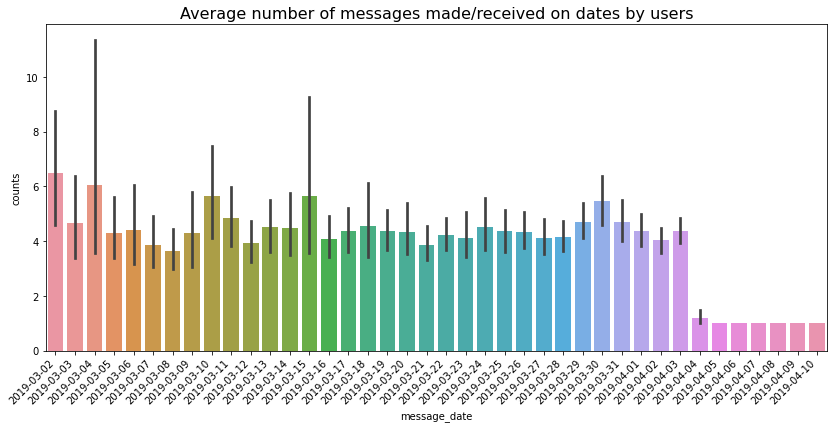

In [120]:
# 1. Visualize count of users on each date 

user_date_df = message_df.groupby(['user_id', pd.Grouper(key= 'message_date', freq='D')])['message_date'].count().reset_index(name = 'counts')
x_dates = message_df['message_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x = 'message_date', y= 'counts',  data = user_date_df)
ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Average number of messages made/received on dates by users', fontsize = 16)

plt.show()

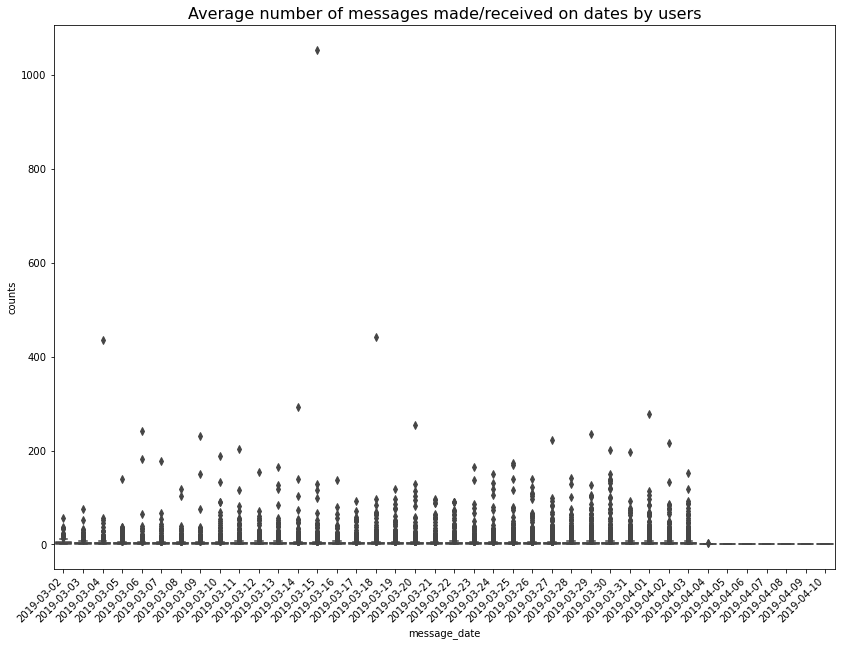

In [121]:
# Box plot to see the distribution on each day and find anomaly.
fig, ax = plt.subplots(figsize=(14,10))

sns.boxplot(x = 'message_date', y= 'counts',  data = user_date_df)
ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Average number of messages made/received on dates by users', fontsize = 16)

plt.show()

The bar plot shows the mean values and provides some indication of the uncertainty around that estimate using error bars. It shows that the distribution of the average value of messages are almost similar on each date. The higest average value is close to 7 messages on the date 2nd march 2019. 

In addition, from the boxplot next, suggests that we have some highly spread distribution with outliers of these average numbers on some dates.

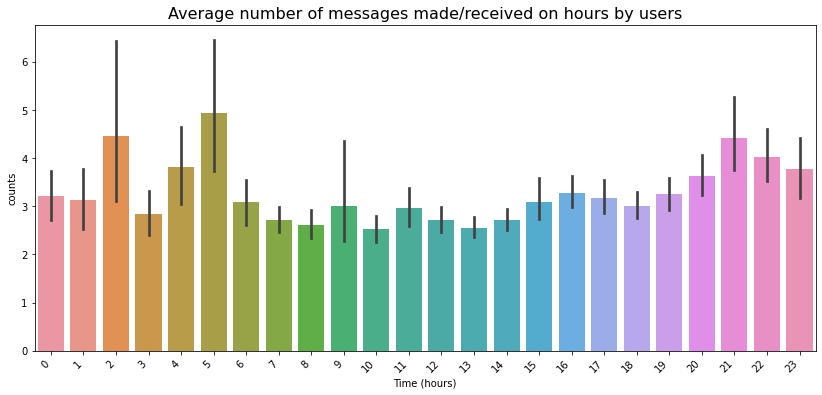

In [130]:
# 1. Visualize count of users on each hour 

user_hour_df = message_df.groupby([ 'user_id', pd.Grouper(key= 'message_date', freq='H')])['message_date'].count().reset_index(name = 'counts')
x_hours = message_df['message_date'].dt.hour.sort_values().unique()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x = user_hour_df['message_date'].dt.hour, y= 'counts',  data = user_hour_df)
ax.set_xticklabels(labels= x_hours, rotation=45, ha='right') 
ax.set_xlabel('Time (hours)')
ax.set_title('Average number of messages made/received on hours by users', fontsize = 16)

plt.show()


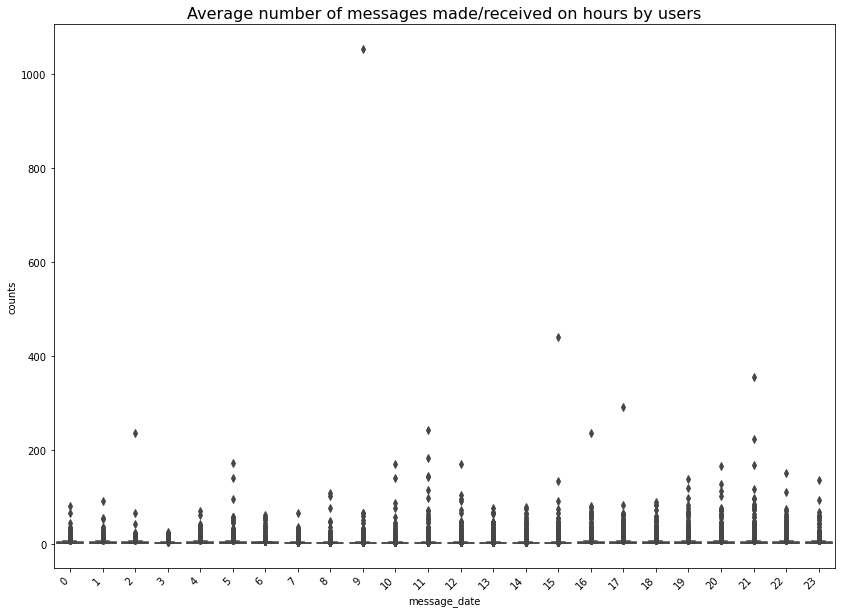

In [125]:
# Box plot to see the distribution on each day and find anomaly.
fig, ax = plt.subplots(figsize=(14,10))

sns.boxplot(x = user_hour_df['message_date'].dt.hour, y= 'counts',  data = user_hour_df)
ax.set_xticklabels(labels= x_hours, rotation=45, ha='right') 
ax.set_title('Average number of messages made/received on hours by users', fontsize = 16)

plt.show()

From the bar plot, we know that threre were on average higest 5 messages made/received by users at time 5 o'clock. 

In addition, from the boxplot next, suggests that we have a very spread distribution for this message data on each hour. The points outside the box are particularly outliers as there are not included in the box of other observations. This infer that, there exist high anomalies/outliers.

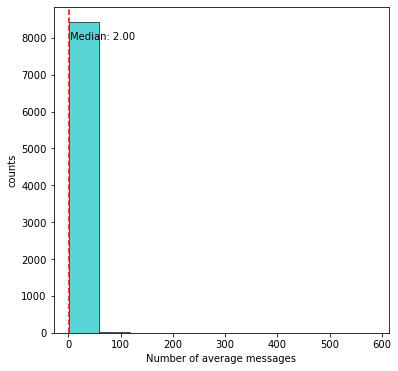

In [126]:
# Visualize the distribution of average users call made/received per day

user_date_df= message_df.groupby(['user_id', pd.Grouper(key= 'message_date', freq= 'D')])['user_id'].count().\
                reset_index(name= 'counts')
average = user_date_df.groupby('user_id')['counts'].mean().reset_index(name= 'average')

plt.figure(figsize=(6,6))
plt.hist(average['average'], bins=10, color='c', edgecolor='k', alpha=0.65)
plt.xlabel('Number of average messages')
plt.ylabel('counts')
plt.axvline(average['average'].median(), color='r', linestyle='dashed', linewidth=1.5)
min_ylim, max_ylim = plt.ylim()
# Plot the median value
plt.text(average['average'].median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(average['average'].median()))

plt.show()

On average the number of messages made/received per day by each user is 2. Note that as the distribution is highly skewed, median is the most robast estimate for getting the central tendency of data instead of mean.

In [823]:
#message_df['date']= message_df['message_date'].dt.strftime('%Y-%m-%d')
#average = message_df.groupby('user_id').agg(
#                                        freq = ('message_date', 'count'),
#                                        unique_date = ('date', pd.Series.nunique)
#                                        )
#average['average'] = round(average['freq']/average['unique_date'], 2)

### Visualization of Search dataframe

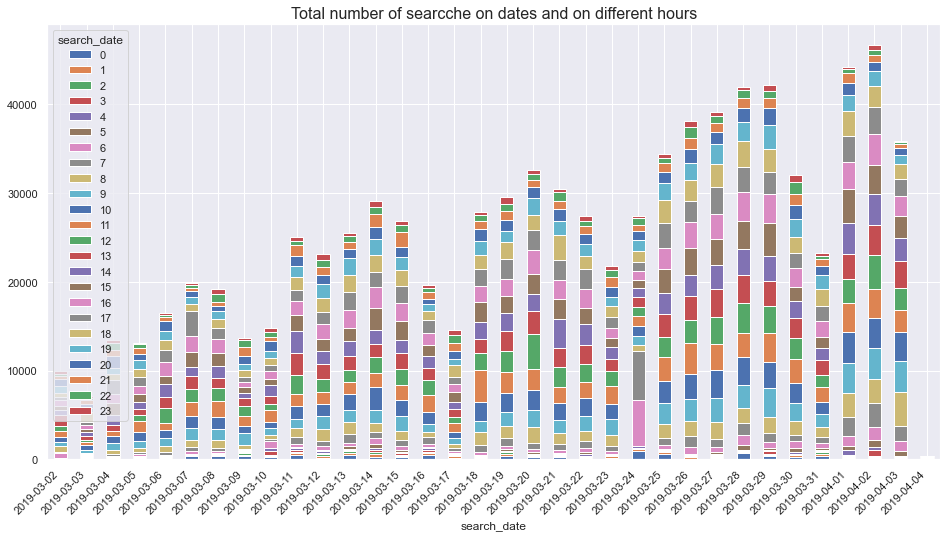

In [68]:
# 1. Visualize count of users on each date 
# Stacked bar char using pandast plot()

x_dates = search_df['search_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

sns.set()

fig, ax = plt.subplots(figsize=(16,8))

search_df.groupby([search_df['search_date'].dt.strftime('%Y-%m-%d'), search_df['search_date'].dt.hour ]).size()\
                    .unstack() \
                    .plot(kind='bar',stacked=True,  ax= ax) 

ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Total number of searcche on dates and on different hours', fontsize = 16)

plt.show()

The plot above suggests, it is a up and down trend with more search on 2nd of April 2019. It also shows that more searches during day time between 8 to 16 o'clock.

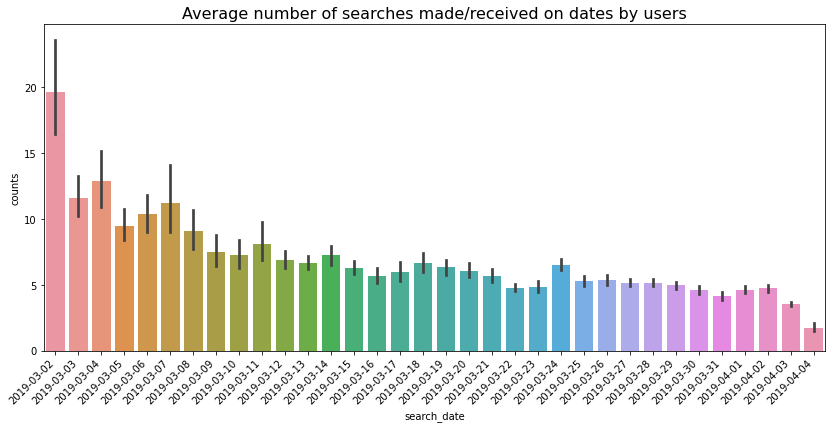

In [128]:
# 1. Visualize count of users on each date 

user_date_df = search_df.groupby(['user_id', pd.Grouper(key= 'search_date', freq='D')])['search_date'].count().reset_index(name = 'counts')
x_dates = search_df['search_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x = 'search_date', y= 'counts',  data = user_date_df)
ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Average number of searches made/received on dates by users', fontsize = 16)

plt.show()

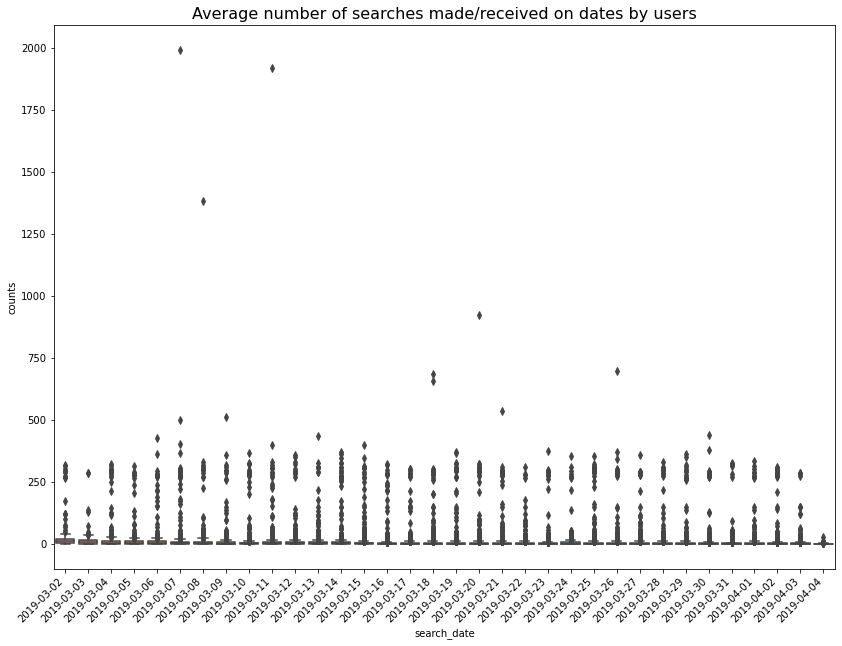

In [129]:
# Box plot to see the distribution on each day and find anomaly.
fig, ax = plt.subplots(figsize=(14,10))

sns.boxplot(x = 'search_date', y= 'counts',  data = user_date_df)
ax.set_xticklabels(labels= x_dates, rotation=45, ha='right') 
ax.set_title('Average number of searches made/received on dates by users', fontsize = 16)

plt.show()

The bar plot shows mean values and provides some indication of the uncertainty around that estimate using error bars. It reveals that the average number of searches by users decreases over time.  

In addition, from the boxplot next, suggests that we have some highly spread distribution with outliers at the beginning of the dates.

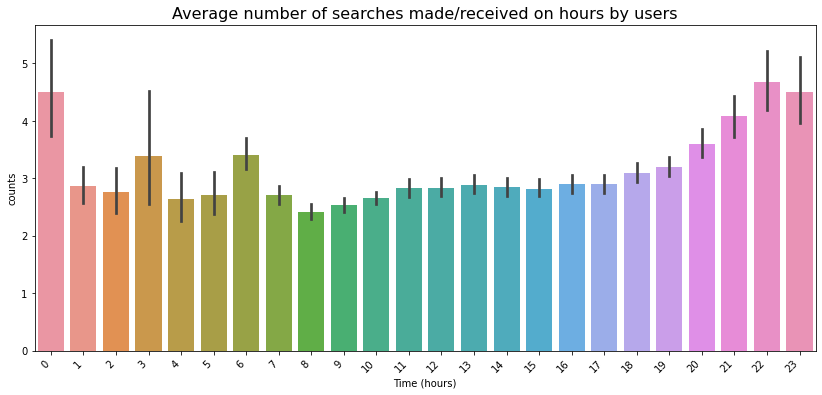

In [131]:
# 1. Visualize count of users on each hour 

user_hour_df = search_df.groupby([ 'user_id', pd.Grouper(key= 'search_date', freq='H')])['search_date'].count().reset_index(name = 'counts')
x_hours = search_df['search_date'].dt.hour.sort_values().unique()

fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(x = user_hour_df['search_date'].dt.hour, y= 'counts',  data = user_hour_df)
ax.set_xticklabels(labels= x_hours, rotation=45, ha='right') 
ax.set_xlabel('Time (hours)')
ax.set_title('Average number of searches made/received on hours by users', fontsize = 16)

plt.show()


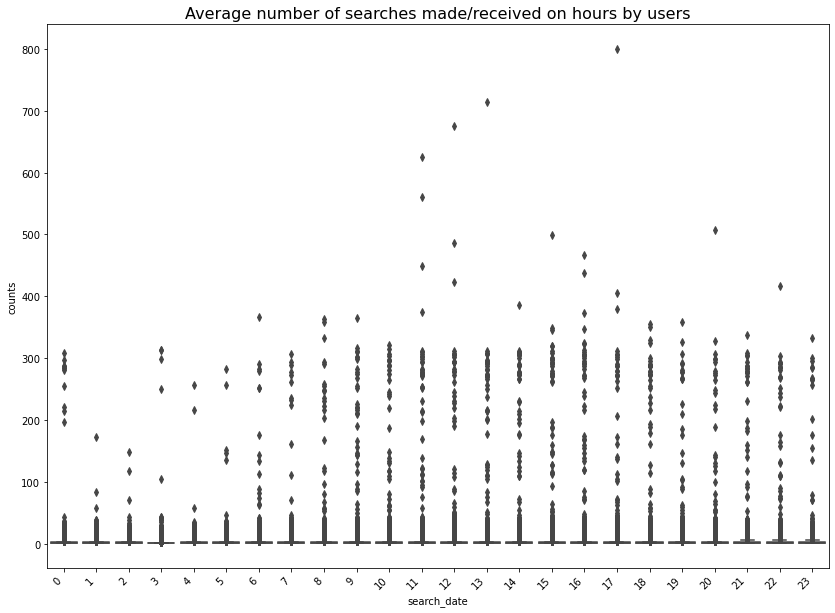

In [132]:
# Box plot to see the distribution on each day and find anomaly.
fig, ax = plt.subplots(figsize=(14,10))

sns.boxplot(x = user_hour_df['search_date'].dt.hour, y= 'counts',  data = user_hour_df)
ax.set_xticklabels(labels= x_hours, rotation=45, ha='right') 
ax.set_title('Average number of searches made/received on hours by users', fontsize = 16)

plt.show()

From the bar plot, we can observe that threre were higest 5 searches made on average for each user and searches are high during 22-00 o'clock. 

In addition, the boxplot next suggests that the distribution of the average messages on dates are spreading a lot with their outlier values.

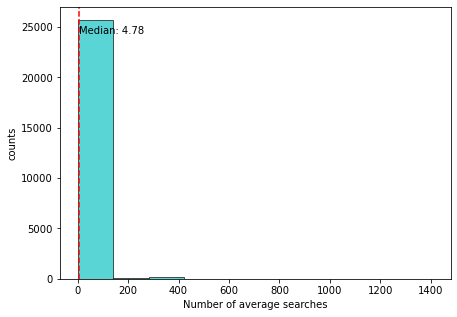

In [135]:
# Visualize the distribution of average users call made/received per day

user_date_df= search_df.groupby(['user_id', pd.Grouper(key= 'search_date', freq= 'D')])['user_id'].count().\
                reset_index(name= 'counts')
average = user_date_df.groupby('user_id')['counts'].mean().reset_index(name= 'average')

plt.figure(figsize=(7,5))
plt.hist(average['average'], bins=10, color='c', edgecolor='k', alpha=0.65)
plt.xlabel('Number of average searches')
plt.ylabel('counts')
plt.axvline(average['average'].median(), color='r', linestyle='dashed', linewidth=1.5)
min_ylim, max_ylim = plt.ylim()
# Plot the median value
plt.text(average['average'].median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(average['average'].median()))

plt.show()

On average the number of searches made/received per day by user is 5. Note that as the distribution is highly skewed, median is the most robast estimate for getting the central tendency of data instead of mean.

In [830]:
search_df['date']= search_df['search_date'].dt.strftime('%Y-%m-%d')
average = search_df.groupby('user_id').agg(
                                        freq = ('search_date', 'count'),
                                        unique_date = ('date', pd.Series.nunique)
                                        )
average['average'] = round(average['freq']/average['unique_date'], 2)


plt.hist(average['average'], bins=20, color='c', edgecolor='k', alpha=0.65)
plt.axvline(average['average'].median(), color='r', linestyle='dashed', linewidth=1.5)
min_ylim, max_ylim = plt.ylim()
plt.text(average['average'].median()*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(average['average'].median()))

plt.show()

# Fraudulent/ Scrapers Activity

## Finding Outliers from Search dataset

### Discover outliers with mathematical function Z-Score

Z-Score greater than 3 consider as outlier and that includes almost 99.7% of our data.


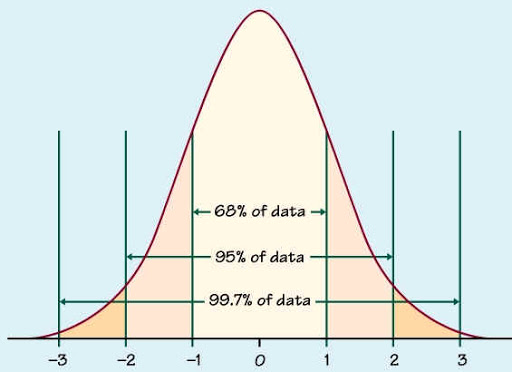

The picture above shows taht if we take data within 3 standard deviation from a standard normal distiribution then it considers about 99.7% of our data. Outside of this range are consider as outliers. Therefor we check for outliers on our search dataframe  and find users which falls outside of this 3 standard deviation.

In [8]:
import gc
# free up some memory
gc.collect()

64

In [9]:
outliers_list = [] 
dates = search_df['search_date'].dt.strftime('%Y-%m-%d').sort_values().unique()

for date in dates:
    date_df = search_df[search_df.search_date.dt.strftime('%Y-%m-%d') == date]
    hour_df = date_df.groupby(['user_id', pd.Grouper(key= 'search_date', freq = 'H')])['user_id'].count() \
                   .reset_index(name = 'counts')

    outlier = hour_df[(np.abs(zscore(hour_df.counts)) > 3)].user_id.tolist() 
    outliers_list.append(outlier)

# Given a list of lists in 'outliers'
flat_list = [item for sublist in outliers_list for item in sublist]

outliers = list(set(flat_list)) # remove duplicate elements
print('Number of anomaly user_ids from search dataframe: {}'.format(len(outliers)))


Number of anomaly user_ids from search dataframe: 1260


In [10]:
call_date_df = call_df.groupby(['user_id', pd.Grouper(key= 'call_date', freq='D')])['call_date'].count().reset_index(name = 'counts')
call_date_max = call_date_df.groupby('user_id')['counts'].max().reset_index(name = 'max')

message_date_df = message_df.groupby(['user_id', pd.Grouper(key= 'message_date', freq='D')])['message_date'].count().reset_index(name = 'counts')
message_date_max = message_date_df.groupby('user_id')['counts'].max().reset_index(name = 'max')

search_date_df = search_df.groupby(['user_id', pd.Grouper(key= 'search_date', freq='D')])['search_date'].count().reset_index(name = 'counts')
search_date_max = search_date_df.groupby('user_id')['counts'].max().reset_index(name = 'max')
#cal_outliers = call_date_df[call_date_df.counts >50]

In [11]:
def mergeDFs(df1, df2, df3, df4):
    
    # Get the time of the first activity per user and merge all four datasets
    
    call_df2 = call_df.groupby('user_id', as_index=False)['call_date'].min()
    message_df2 = message_df.groupby('user_id', as_index=False)['message_date'].min()
    search_df2 =search_df.groupby('user_id', as_index=False)['search_date'].min()

    merge_df = pd.merge(call_df2, message_df2, on = 'user_id', how = 'outer')
    merge_df = pd.merge(merge_df, search_df2,  on = 'user_id', how = 'outer')
    merge_df = pd.merge(merge_df, signup_df,  on = 'user_id', how = 'outer')

    return merge_df

In [12]:
user_df = mergeDFs(call_df, message_df, search_df, signup_df )
print(user_df.shape)
user_df.head()

(26000, 8)


,user_id,call_date,message_date,search_date,country_code,signup_ts,signup_date,day
0,10000000,2019-03-19 07:41:26.148,2019-04-02 16:55:06.197,2019-03-18 19:06:00.635,IT,1552867200000,2019-03-18,Monday
1,10000001,2019-03-04 00:44:47.577,NaT,2019-03-03 13:57:40.041,IT,1551571200000,2019-03-03,Sunday
2,10000002,2019-04-02 22:10:07.048,2019-04-03 12:04:51.344,2019-04-02 13:09:23.146,SE,1554163200000,2019-04-02,Tuesday
3,10000003,2019-03-27 16:51:28.872,NaT,2019-03-27 11:55:39.487,IT,1553644800000,2019-03-27,Wednesday
4,10000004,2019-04-02 04:02:43.526,NaT,2019-04-01 21:10:00.782,IT,1554076800000,2019-04-01,Monday


In [13]:
# The suspicious activity is, if search date is before the signup date
search_before_signup = user_df[user_df.search_date.dt.strftime('%Y-%m-%d') < user_df.signup_date.dt.strftime('%Y-%m-%d')]
search_before_signup.country_code.value_counts()

ES    358
IT    144
Name: country_code, dtype: int64

In [14]:
# users have suspicious activity, if search_date is smaller than call_date or message date
fraud_df = user_df[((user_df.search_date.dt.strftime('%Y-%m-%d %H:%M') <= user_df.call_date.dt.strftime('%Y-%m-%d  %H:%M')) | 
                    (user_df.search_date.dt.strftime('%Y-%m-%d %H:%M') <= user_df.message_date.dt.strftime('%Y-%m-%d %H:%M'))) &
                  (user_df.user_id.isin(outliers))]
fraud_df

,user_id,call_date,message_date,search_date,country_code,signup_ts,signup_date,day
4,10000004,2019-04-02 04:02:43.526,NaT,2019-04-01 21:10:00.782,IT,1554076800000,2019-04-01,Monday
30,10000031,2019-03-18 18:44:33.078,2019-03-19 08:22:42.612,2019-03-18 09:54:52.738,SE,1552867200000,2019-03-18,Monday
79,10000082,2019-03-16 09:36:28.588,NaT,2019-03-11 20:01:57.484,GB,1552262400000,2019-03-11,Monday
84,10000087,2019-03-16 13:24:29.691,2019-03-15 00:11:52.540,2019-03-13 07:55:59.967,FR,1552435200000,2019-03-13,Wednesday
102,10000108,2019-03-18 07:59:16.277,2019-03-16 13:01:58.058,2019-03-15 13:37:13.684,SE,1552608000000,2019-03-15,Friday
...,...,...,...,...,...,...,...,...
24758,10014786,NaT,2019-03-30 14:42:51.607,2019-03-30 11:39:01.170,FR,1553904000000,2019-03-30,Saturday
24766,10015261,NaT,2019-04-03 09:00:45.956,2019-04-01 17:17:59.959,GB,1554076800000,2019-04-01,Monday
24826,10018269,NaT,2019-03-30 17:20:39.719,2019-03-29 10:35:22.854,SE,1553817600000,2019-03-29,Friday
24874,10020746,NaT,2019-04-02 08:43:24.930,2019-03-29 19:14:31.166,ES,1553817600000,2019-03-29,Friday


### Get the fraud user_id list

In [15]:
# join to lists
 #select column to convert to list here
final_list =  list(set(fraud_df.user_id.tolist() +  search_before_signup.user_id.tolist() )) #set() remove duplicates if exists
len(final_list)

1385

In [16]:
# Save fraudulent user_ids as csv

df = pd.DataFrame({'user_id': final_list})
df.to_csv('fraud_user_id.csv', index= False )


In [17]:
df_list = ['call_df', 'message_df', 'search_df', 'signup_df']

for df in df_list:
    print("\nSummary statistics for: " + df + "\n")
    tmp = eval(df).groupby(['user_id', pd.Grouper(key = df.split('_')[0] +'_date', freq= 'D')])['user_id'].count().reset_index(name = 'counts')
    print(tmp.groupby('user_id').agg({'counts':['min', 'max','median', 'mean','std']}).rename(columns= {'counts':'statistics'}))
    


Summary statistics for: call_df

         statistics                                 
                min max median       mean        std
user_id                                             
10000000          1   6    2.0   2.769231   1.921538
10000001          3  27   17.0  16.000000  10.392305
10000002          2   3    2.5   2.500000   0.707107
10000003          3  22    4.0   7.500000   6.740072
10000004          7  17   12.0  12.000000   7.071068
...             ...  ..    ...        ...        ...
10025995          4  10    7.0   7.000000   4.242641
10025996         14  20   17.0  17.000000   4.242641
10025997          2  29    9.0  12.142857   8.783101
10025998          2   6    4.0   4.000000   1.632993
10025999          1  24    7.0   9.000000   6.855655

[24439 rows x 5 columns]

Summary statistics for: message_df

         statistics                         
                min max median mean      std
user_id                                     
10000000          1   1   

# Summary

### What might activity from fraud/scrapers look like?

-	User has more search records on a given timestamp than normal users have on the search dataset.
-   If for a user the search takes too long time then it also can be a scenario of suspicious activity.
-	Another fraudulent activity could be, user made a search first and gather information and then make call and send messages.
-	Fraudulent activity usually happens during night between 21-00 o’clock 
-	Suspicious activities may also happen when search date is smaller than signup date which is beyond the normal scenario.

However, it is always challenging to detect anomalies and suspecious activities from data. Domain knowledge and more time spend to inspect data can be possible to find more acurate outcome.